# XGBoost Classifier

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

from xgboost import XGBClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

## Load Split Data

In [3]:
clean_train = "../data/clean/clean_train.csv"
clean_val = "../data/clean/clean_val.csv"
clean_test = "../data/clean/clean_test.csv"
train_subsam = "../data/clean/train_subsam.csv"
train_smote = "../data/clean/train_smote.csv"
xg_boost_model = "../models/xgboost_model.joblib"

rnd_xgb = 44
num_cols = ["Term","NoEmp","SecuredSBA","GrDisburs","GrApprov","ApprovSBA"]
target = "Default"

In [4]:
df_train = pd.read_csv(clean_train, low_memory=False)
df_val = pd.read_csv(clean_val, low_memory=False)
df_test = pd.read_csv(clean_test, low_memory=False)

df_under = pd.read_csv(train_subsam, low_memory=False)
df_smote = pd.read_csv(train_smote, low_memory=False)

In [5]:
X_train = df_train.drop(columns=[target])
X_val = df_val.drop(columns=[target])
X_test = df_test.drop(columns=[target])
X_under = df_under.drop(columns=target)
X_smote = df_smote.drop(columns=target)

y_train = df_train[target]
y_val = df_val[target]
y_test = df_test[target]
y_under = df_under[target]
y_smote = df_smote[target]

In [6]:
print(f"Train: {X_train.shape}, {y_train.shape}")
print(f"Val:   {X_val.shape}, {y_val.shape}")
print(f"Test:  {X_test.shape}, {y_test.shape}\n")

print(f"SubSam: {X_under.shape}, {y_under.shape}")
print(f"SMOTE:  {X_smote.shape}, {y_smote.shape}")

Train: (626670, 18), (626670,)
Val:   (134552, 18), (134552,)
Test:  (134498, 18), (134498,)

SubSam: (219654, 18), (219654,)
SMOTE:  (1033686, 18), (1033686,)


## Model Training

### Model Tuning

In [7]:
param_grid = {"learning_rate": [0.01, 0.1, 0.2],
              "max_depth": [10, 20, 30],
              "random_state": [rnd_xgb]}

In [ ]:
grid_xgb = GridSearchCV(XGBClassifier(), param_grid, cv=10)
grid_xgb.fit(X_train, y_train)

In [19]:
params = grid_xgb.best_params_

print("Better Parameters:", params)

Better Parameters: {'learning_rate': 0.2, 'max_depth': 10, 'random_state': 44}


In [8]:
xgb_model = XGBClassifier(learning_rate=0.2, max_depth=10, random_state=rnd_xgb)

xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=44, ...)

In [10]:
acc_val = xgb_model.score(X_val, y_val)

print("Accuracy Val:", round(acc_val, 4))

Accuracy Val: 0.9539


### Feature Importance

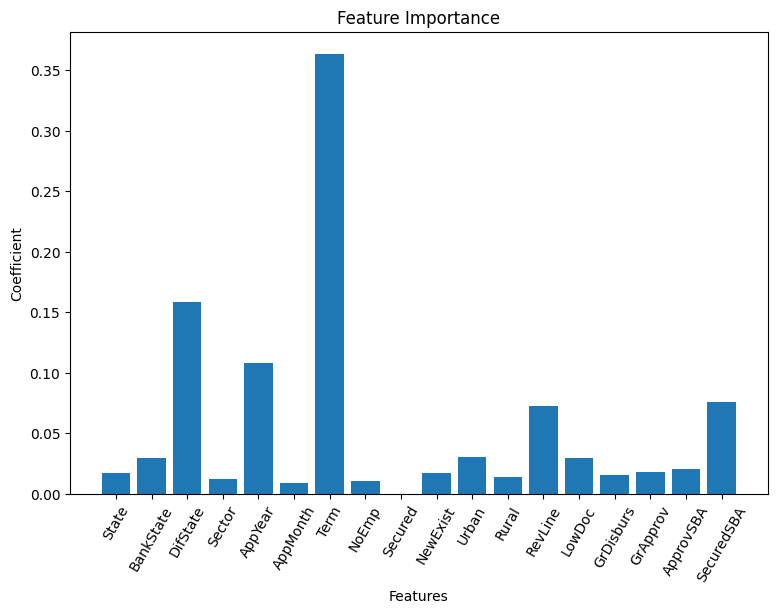

In [11]:
X_cols = X_train.columns
fi_xgb = xgb_model.feature_importances_

plt.figure(figsize=(9, 6))
plt.bar(X_cols, fi_xgb)

plt.title("Feature Importance")
plt.xlabel("Features")
plt.ylabel("Coefficient")
plt.xticks(rotation=60)
plt.show()

### Recursive Feature Elimination

In [12]:
xgb_ref = XGBClassifier(learning_rate=0.2, max_depth=10, random_state=rnd_xgb)

rfe_xgb = RFE(xgb_ref)
rfe_xgb.fit(X_train, y_train)

RFE(estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
                            colsample_bylevel=None, colsample_bynode=None,
                            colsample_bytree=None, device=None,
                            early_stopping_rounds=None,
                            enable_categorical=False, eval_metric=None,
                            feature_types=None, gamma=None, grow_policy=None,
                            importance_type=None, interaction_constraints=None,
                            learning_rate=0.2, max_bin=None,
                            max_cat_threshold=None, max_cat_to_onehot=None,
                            max_delta_step=None, max_depth=10, max_leaves=None,
                            min_child_weight=None, missing=nan,
                            monotone_constraints=None, multi_strategy=None,
                            n_estimators=None, n_jobs=None,
                            num_parallel_tree=None, random_state=44, ...))

In [13]:
rfe_mat = list(zip(X_train.columns.values.tolist(), rfe_xgb.support_, rfe_xgb.ranking_))
rfe_mat

[('State', False, 2),
 ('BankState', True, 1),
 ('DifState', True, 1),
 ('Sector', False, 7),
 ('AppYear', True, 1),
 ('AppMonth', False, 9),
 ('Term', True, 1),
 ('NoEmp', False, 8),
 ('Secured', False, 10),
 ('NewExist', False, 3),
 ('Urban', True, 1),
 ('Rural', False, 6),
 ('RevLine', True, 1),
 ('LowDoc', True, 1),
 ('GrDisburs', False, 5),
 ('GrApprov', False, 4),
 ('ApprovSBA', True, 1),
 ('SecuredSBA', True, 1)]

In [14]:
sel_cols = [tupla[1] for tupla in rfe_mat]
rfe_cols = X_train.loc[:, sel_cols].columns
rfe_cols

Index(['BankState', 'DifState', 'AppYear', 'Term', 'Urban', 'RevLine',
       'LowDoc', 'ApprovSBA', 'SecuredSBA'],
      dtype='object')

In [15]:
xgb_ref.fit(X_train[rfe_cols], y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=44, ...)

In [16]:
y_ref = xgb_ref.predict(X_val[rfe_cols])
acc_ref = accuracy_score(y_val, y_ref)

print("Accuracy REF:", round(acc_ref, 4))

Accuracy REF: 0.9522


### Balanced Datasets

**Subsample Dataset**

In [17]:
xgb_under = XGBClassifier(learning_rate=0.2, max_depth=10, random_state=rnd_xgb)

xgb_under.fit(X_under, y_under)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=44, ...)

In [18]:
acc_under = xgb_under.score(X_val, y_val)

print("Accuracy SubSampling:", round(acc_under, 4))

Accuracy SubSampling: 0.9197


**SMOTE Dataset**

In [19]:
xgb_smote = XGBClassifier(learning_rate=0.2, max_depth=10, random_state=rnd_xgb)

xgb_smote.fit(X_smote, y_smote)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=44, ...)

In [20]:
acc_smote = xgb_smote.score(X_val, y_val)

print("Accuracy SMOTE:", round(acc_smote, 4))

Accuracy SMOTE: 0.9269


## Model Evaluation

### Cross-Validation

**Testing the Model**

In [21]:
results = cross_val_score(xgb_model, X_test, y_test, cv=10)

print("Results:", results)
print("Accuracy Test (mean +/- desv): %0.4f +/- %0.4f" % (results.mean(), results.std()))

Results: [0.95040892 0.94892193 0.94996283 0.94869888 0.94587361 0.95070632
 0.95026022 0.9470632  0.95070265 0.95181798]
Accuracy Test (mean +/- desv): 0.9494 +/- 0.0017


In [22]:
y_cv_test = cross_val_predict(xgb_model, X_test, y_test, cv=10)
acc_cv_test = accuracy_score(y_test, y_cv_test)

print("Accuracy Test:", round(acc_cv_test, 4))

Accuracy Test: 0.9494


**Model Scores**

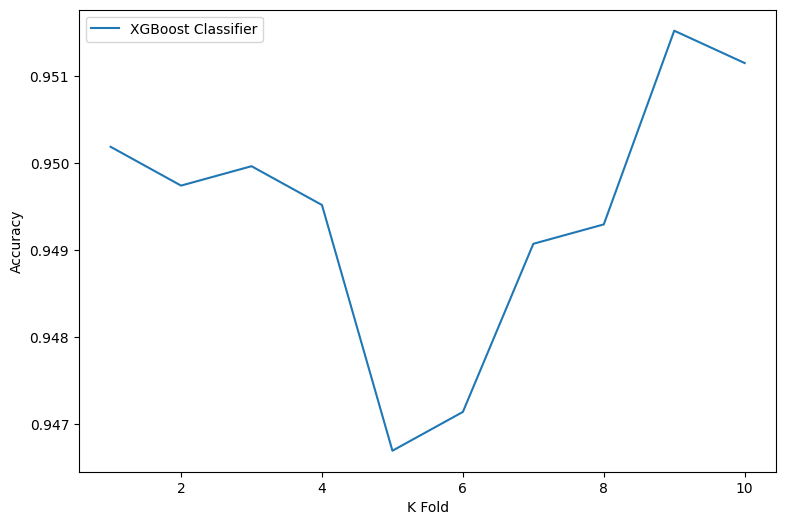

In [23]:
kf = KFold(n_splits=10, shuffle=True)
scores = cross_val_score(xgb_model, X_test, y_test, cv=kf, scoring="accuracy")

plt.figure(figsize=(9, 6))
plt.plot(range(1, 11), scores, label="XGBoost Classifier")

plt.xlabel("K Fold")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Classification Metrics

**Classification Report**

In [24]:
y_pred = xgb_model.predict(X_test)

In [25]:
print("Exactitud:    %.4f" % (accuracy_score(y_test, y_pred)))
print("Precisión:    %.4f" % (precision_score(y_test, y_pred, average="macro")))
print("Sensibilidad: %.4f" % (recall_score(y_test, y_pred, average="macro")))
print("F1-score:     %.4f" % (f1_score(y_test, y_pred, average="macro")))

Exactitud:    0.9533
Precisión:    0.9271
Sensibilidad: 0.9103
F1-score:     0.9184


In [26]:
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9666    0.9769    0.9718    110629
           1     0.8876    0.8436    0.8651     23869

    accuracy                         0.9533    134498
   macro avg     0.9271    0.9103    0.9184    134498
weighted avg     0.9526    0.9533    0.9528    134498



**Confusion Matrix**

In [27]:
cm_xgb = confusion_matrix(y_test, y_pred, normalize="all")
print(cm_xgb)

[[0.80357329 0.01895939]
 [0.02774762 0.1497197 ]]


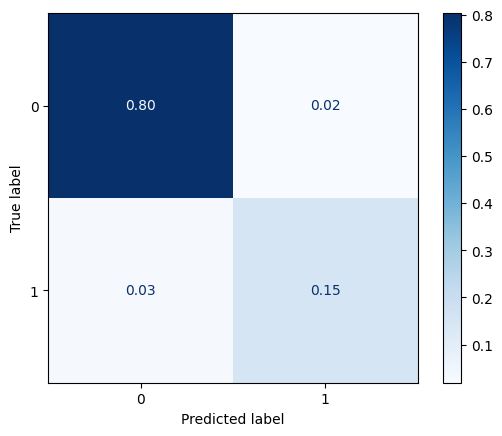

In [28]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb,
                              display_labels=xgb_model.classes_)
disp.plot(cmap="Blues", values_format=".2f")

**ROC (Receiver Operating Characteristic) Curve**

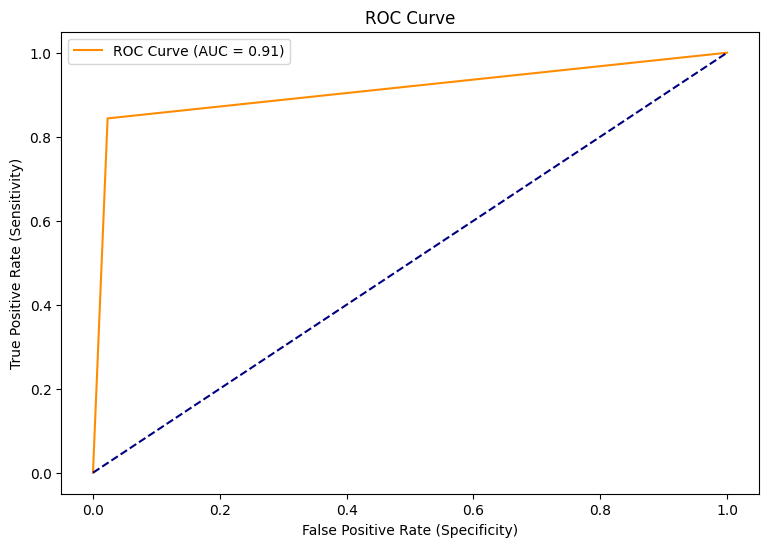

In [29]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(9, 6))
plt.plot(fpr, tpr, color="darkorange", label="ROC Curve (AUC = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")

plt.title("ROC Curve")
plt.xlabel("False Positive Rate (Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.legend()
plt.show()

## Model Pipeline

### Create the Pipeline

In [30]:
class XGBoostModel(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.xgboost = XGBClassifier(learning_rate=0.2,
                                     max_depth=10,
                                     random_state=rnd_xgb)

    def fit(self, X, y):
        self.xgboost.fit(X, y)
        return self

    def predict(self, X, y=None):
        y_pred = self.xgboost.predict(X)
        return y_pred

In [31]:
xgboost_custom = Pipeline([
    ("custom_model", XGBoostModel())
    ])

### Test the Pipeline

**Internal Partition**

In [32]:
xgboost_custom.fit(X_train, y_train)

y_pred = xgboost_custom.predict(X_val)

In [33]:
print("Exactitud:    %.4f" % (accuracy_score(y_val, y_pred)))
print("Precisión:    %.4f" % (precision_score(y_val, y_pred, average="macro")))
print("Sensibilidad: %.4f" % (recall_score(y_val, y_pred, average="macro")))
print("F1-score:     %.4f" % (f1_score(y_val, y_pred, average="macro")))

Exactitud:    0.9539
Precisión:    0.9272
Sensibilidad: 0.9123
F1-score:     0.9195


**External Partition**

In [34]:
X_train_val = pd.concat([X_train, X_val], axis=0)
y_train_val = pd.concat([y_train, y_val], axis=0)

xgboost_custom.fit(X_train_val, y_train_val)

y_pred = xgboost_custom.predict(X_test)

In [35]:
print("Exactitud:    %.4f" % (accuracy_score(y_test, y_pred)))
print("Precisión:    %.4f" % (precision_score(y_test, y_pred, average="macro")))
print("Sensibilidad: %.4f" % (recall_score(y_test, y_pred, average="macro")))
print("F1-score:     %.4f" % (f1_score(y_test, y_pred, average="macro")))

Exactitud:    0.9541
Precisión:    0.9282
Sensibilidad: 0.9121
F1-score:     0.9199


**The Best Model**

In [36]:
xgboost_custom.fit(X_train_val, y_train_val)

y_pred = xgboost_custom.predict(X_test)

In [37]:
print("Exactitud:    %.4f" % (accuracy_score(y_test, y_pred)))
print("Precisión:    %.4f" % (precision_score(y_test, y_pred, average="macro")))
print("Sensibilidad: %.4f" % (recall_score(y_test, y_pred, average="macro")))
print("F1-score:     %.4f" % (f1_score(y_test, y_pred, average="macro")))

Exactitud:    0.9541
Precisión:    0.9282
Sensibilidad: 0.9121
F1-score:     0.9199


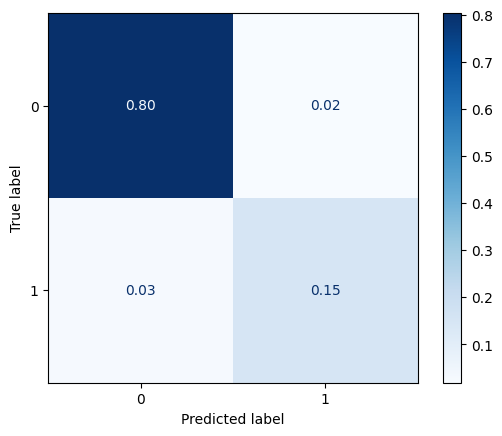

In [38]:
cm_xgb = confusion_matrix(y_test, y_pred, normalize="all")

disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb,
                              display_labels=xgb_model.classes_)
disp.plot(cmap="Blues", values_format=".2f")

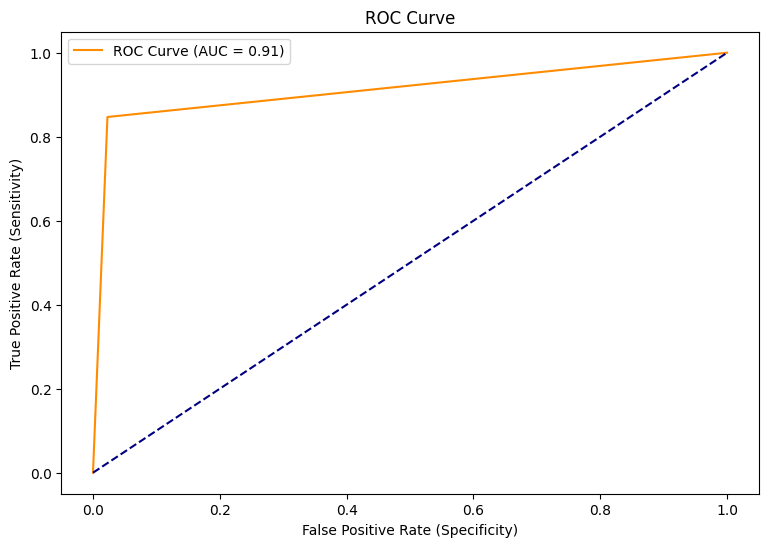

In [39]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(9, 6))
plt.plot(fpr, tpr, color="darkorange", label="ROC Curve (AUC = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")

plt.title("ROC Curve")
plt.xlabel("False Positive Rate (Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.legend()
plt.show()

### Save the Model

In [40]:
try:
    joblib.dump(xgboost_custom, xg_boost_model)

    xgboost_model = joblib.load(xg_boost_model)
    print(f"XGBoost Classifier is loaded...")

except Exception as err:
    print("Error:", str(err))

XGBoost Classifier is loaded...


In [41]:
y_pred = xgboost_model.predict(X_test)
df_ = pd.concat([X_test, y_test, pd.DataFrame({"Pred": y_pred})], axis=1)

In [45]:
df_.sample(10)

,State,BankState,DifState,Sector,AppYear,AppMonth,Term,NoEmp,Secured,NewExist,Urban,Rural,RevLine,LowDoc,GrDisburs,GrApprov,ApprovSBA,SecuredSBA,Default,Pred
114168,14,49,1,4,40,9,108,2,0,0,0,1,0,0,150000,150000,75000,50,0,0
130789,21,24,0,10,40,12,36,6,0,0,0,1,1,0,40741,20000,10000,50,0,0
54214,23,26,0,16,25,5,48,3,0,1,0,0,0,0,50000,50000,45000,90,0,0
21510,40,5,1,7,41,7,55,1,0,1,1,0,0,0,5000,5000,4250,85,1,1
100552,43,47,0,13,31,1,72,1,0,0,0,0,0,1,20000,20000,18000,90,0,0
117529,19,22,0,20,34,4,60,3,0,1,0,0,0,1,40000,40000,32000,80,0,0
65568,24,30,1,16,31,11,60,2,0,1,0,0,0,0,20000,20000,10000,50,0,0
83111,19,9,1,10,42,5,11,3,0,0,1,0,1,0,50000,25000,12500,50,1,1
19372,47,52,0,10,41,5,120,4,0,0,0,1,0,1,150000,150000,127500,85,0,0
76134,42,46,0,16,36,11,60,3,0,0,1,0,0,1,50000,50000,40000,80,0,0
